/tmp/ipython-input-3675817396.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2010-01-01', periods=n_samples, freq='M')


Fitting the SARIMAX model...
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  170
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -375.316
Date:                            Thu, 29 Jan 2026   AIC                            762.631
Time:                                    10:06:30   BIC                            780.408
Sample:                                01-31-2010   HQIC                           769.855
                                     - 02-29-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              2.1564      0.262      8.246      0.000       1.644       2.669
ar.L1 

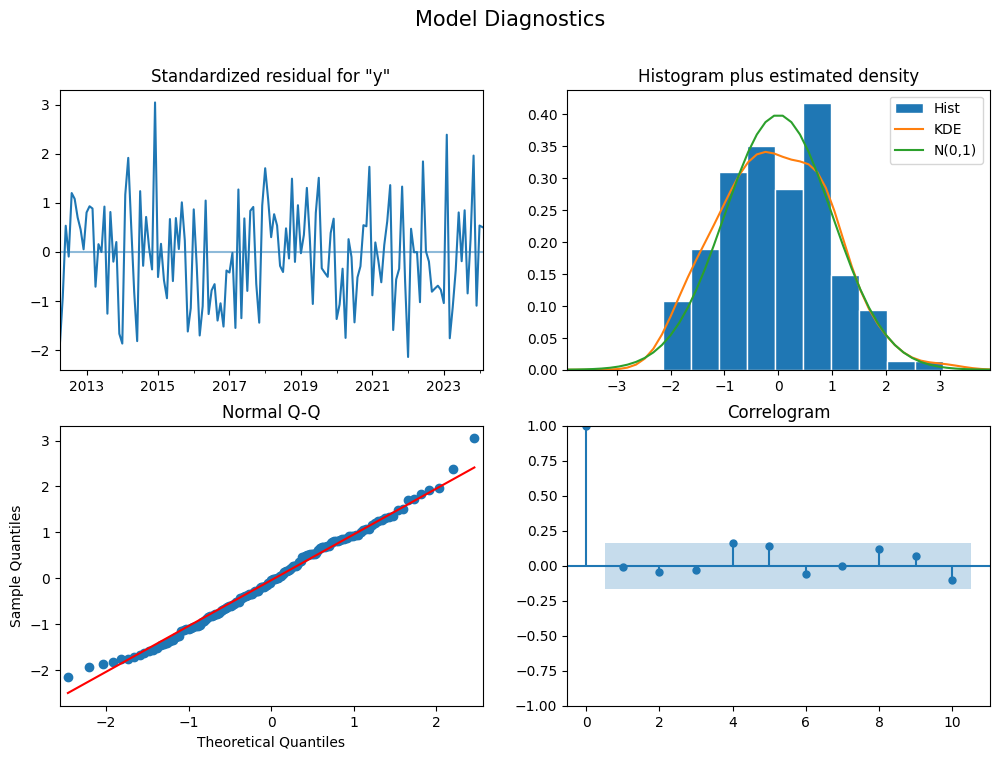

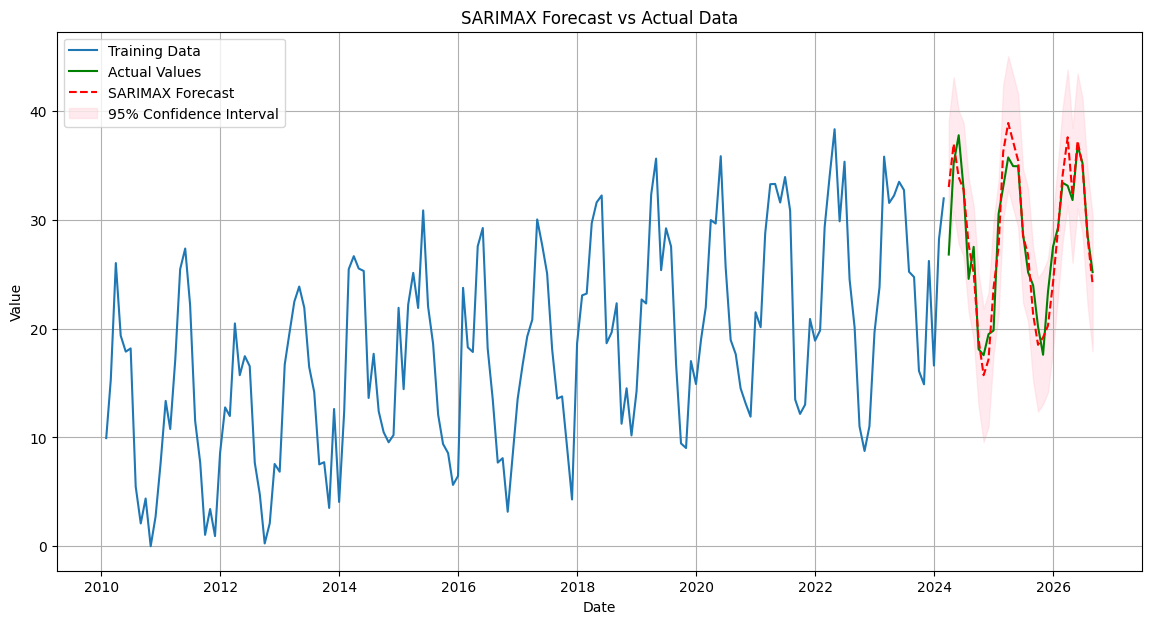

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Data Generation
# I'm creating a synthetic dataset to demonstrate the model.
# It includes a trend, a seasonal pattern, an exogenous variable, and random noise.
np.random.seed(123)
n_samples = 200
t = np.arange(n_samples)

# Create an exogenous variable (e.g., ad spend, temperature)
exog = np.random.normal(5, 1, n_samples)

# Generate the target time series: Linear Trend + Seasonality + Exogenous Impact + Noise
# Seasonality is simulated with a sine wave
seasonality = 10 * np.sin(2 * np.pi * t / 12)
trend = 0.1 * t
noise = np.random.normal(0, 3, n_samples)
data = trend + seasonality + (2 * exog) + noise

# Convert to pandas Series for easier handling
# I'm setting a frequency of 'M' (Month) to simulate monthly data
dates = pd.date_range(start='2010-01-01', periods=n_samples, freq='M')
ts_data = pd.Series(data, index=dates)
exog_data = pd.Series(exog, index=dates)

# 2. Train/Test Split
# I'm holding back the last 24 months to validate my model's performance.
train_size = int(len(ts_data) * 0.85)
train_data, test_data = ts_data[:train_size], ts_data[train_size:]
train_exog, test_exog = exog_data[:train_size], exog_data[train_size:]

# 3. Define and Fit the SARIMAX Model
# I am using order=(1, 1, 1) for ARIMA and seasonal_order=(1, 1, 1, 12)
# because my data has a monthly cycle (12).
print("Fitting the SARIMAX model...")
model = SARIMAX(endog=train_data,
                exog=train_exog,
                order=(1, 1, 1),              # (p, d, q)
                seasonal_order=(1, 1, 1, 12), # (P, D, Q, s)
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# 4. Diagnostics and Summary
# I'll print the summary to check p-values and AIC/BIC scores.
print(model_fit.summary())

# I'm also plotting diagnostic charts to ensure residuals are normally distributed
# and uncorrelated.
model_fit.plot_diagnostics(figsize=(12, 8))
plt.suptitle('Model Diagnostics', fontsize=15)
plt.show()

# 5. Forecasting
# I predict on the test set, providing the future exogenous values required for calculation.
forecast = model_fit.get_forecast(steps=len(test_data), exog=test_exog)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# 6. Visualization of Results
plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(train_data.index, train_data, label='Training Data')

# Plot actual test data
plt.plot(test_data.index, test_data, label='Actual Values', color='green')

# Plot forecast
plt.plot(forecast_mean.index, forecast_mean, label='SARIMAX Forecast', color='red', linestyle='--')

# Plot confidence intervals (uncertainty area)
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('SARIMAX Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()